
# Dithering Telescope - random offsets
In this notebook, one can set a sky position to look at (boresight position) and a source (with profile and position) and study the effect of possible telescope offsets (such as fiber positioner offset, boresight offsets) on the signal-to-noise ratio (SNR).


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append('../../py')
import dithering


After the general packages and the special package "dithering" is imported, one start with setting the source and boresight positions. By default, "generate_source()" function generates a source like a QSO. For other types of sources, you can uncomment/comment the lines below.


### Constructing the object

One can uncomment/comment a source below to study

In [2]:
dit    = dithering.dithering("../../config/desi-blur.yaml")
# QSO
#source = dit.generate_source(disk_fraction=0., bulge_fraction=0.)
#source_type = 'qso'
# ELG
source = dit.generate_source(disk_fraction=1., bulge_fraction=0.)
source_type = 'elg'
# LRG
#source = dit.generate_source(disk_fraction=0., bulge_fraction=1.)
#source_type = 'lrg'
dit.set_source_position(20.*u.deg, 25.*u.deg)
dit.set_boresight_position(20.*u.deg, 24.5*u.deg)
dit.set_focal_plane_position()
dit.run_simulation(source_type, *source, report=True)

boresight position is   : 20.000 deg , 24.500 deg
source position is      : 20.000 deg , 25.000 deg
fiber position is       : 119.067 mm , 0.178 mm
focal plane position is : 119.067 mm , 0.178 mm
fiber placement         : [ 0.] um, [ 0.] um
With the current configuration, SNR are:
-- camera r: 2.807 / 0.5 Angstrom
-- camera z: 2.050 / 0.5 Angstrom
-- camera b: 3.549 / 0.5 Angstrom


### Rotating the positioner along $\Phi$ and $\Theta$

If the fiber aperture is not covering the source, we may have to move the fiber around a bit to find the maximum
The example below starts from -2 degrees and scans up to 2 degrees to find the maximum.

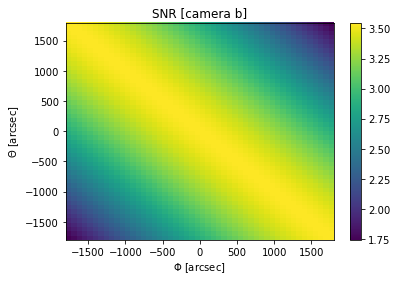

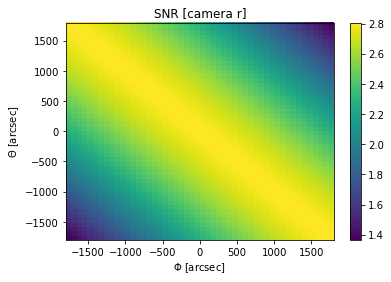

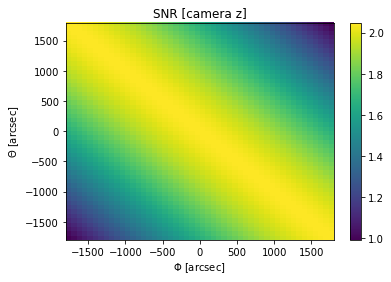

In [3]:
#dit.change_alt_az_bore_position(20.*u.deg, 24.5*u.deg)
nbins = 50
#dit.set_focal_plane_position()
rotations = np.linspace(-.5, .5, nbins)
dit.set_positioner_theta(0*u.deg)
dit.set_positioner_phi(0*u.deg)
dit.make_positioner_rotation()
thetas = []
phis   = []
SNR_b  = []
SNR_r  = []
SNR_z  = []
for i in range(nbins):
    for j in range(nbins):
        dit.set_positioner_phi(rotations[i]*u.deg)
        dit.set_positioner_theta(rotations[j]*u.deg)
        dit.make_positioner_rotation()
        dit.run_simulation(source_type, *source, report=False)
        phis.append((rotations[i]*u.deg).to(u.arcsec).value)
        thetas.append((rotations[j]*u.deg).to(u.arcsec).value)
        SNR_b.append(np.median(dit.SNR['b'][0]))
        SNR_r.append(np.median(dit.SNR['r'][0]))
        SNR_z.append(np.median(dit.SNR['z'][0]))
# camera b
plt.hist2d(phis, thetas, weights=SNR_b, bins=nbins)
plt.xlabel("$\Phi$ [arcsec]")
plt.ylabel("$\Theta$ [arcsec]")
plt.title("SNR [camera b]")
plt.colorbar()
plt.show()
# camera r
plt.hist2d(phis, thetas, weights=SNR_r, bins=nbins)
plt.xlabel("$\Phi$ [arcsec]")
plt.ylabel("$\Theta$ [arcsec]")
plt.title("SNR [camera r]")
plt.colorbar()
plt.show()
# camera z
plt.hist2d(phis, thetas, weights=SNR_z, bins=nbins)
plt.xlabel("$\Phi$ [arcsec]")
plt.ylabel("$\Theta$ [arcsec]")
plt.title("SNR [camera z]")
plt.colorbar()
plt.show()

### Testing the random offsets - simple case
Here we report some of the conditions of the simulation before we start changing them. Then we add random fiber placement offsets.

In [4]:
print("Nominal results:")
dit.set_positioner_theta(0*u.deg)
dit.set_positioner_phi(0*u.deg)
dit.make_positioner_rotation()
dit.run_simulation(source_type, *source)
# adding some random offset
dit.add_random_offset_fiber_position(var_x=5*u.um)
print("------------------------------")
print("With fiber positioner offsets:")
dit.run_simulation(source_type, *source)

Nominal results:
boresight position is   : 20.000 deg , 24.500 deg
source position is      : 20.000 deg , 25.000 deg
fiber position is       : 119.067 mm , 0.178 mm
focal plane position is : 119.067 mm , 0.178 mm
fiber placement         : [ 0.] um, [ -1.73372428e-12] um
With the current configuration, SNR are:
-- camera r: 2.807 / 0.5 Angstrom
-- camera z: 2.050 / 0.5 Angstrom
-- camera b: 3.549 / 0.5 Angstrom
------------------------------
With fiber positioner offsets:
boresight position is   : 20.000 deg , 24.500 deg
source position is      : 20.000 deg , 25.000 deg
fiber position is       : 119.069 mm , 0.177 mm
focal plane position is : 119.067 mm , 0.178 mm
fiber placement         : [ 1.5410494] um, [-0.57581578] um
With the current configuration, SNR are:
-- camera r: 2.799 / 0.5 Angstrom
-- camera z: 2.044 / 0.5 Angstrom
-- camera b: 3.539 / 0.5 Angstrom


### Testing the random offsets - random fiber positioner offsets

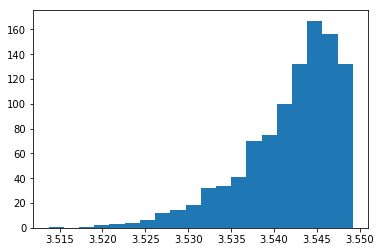

In [5]:
dit.set_positioner_theta(0*u.deg)
dit.set_positioner_phi(0*u.deg)
dit.make_positioner_rotation()
dit.run_simulation(source_type, *source, report=False)
num_iterations = 1000
snr_b = []
snr_r = []
snr_z = []
for i in range(num_iterations):
    # move the fiber to its initial point before randomly moving it
    dit.set_focal_plane_position()
    dit.add_random_offset_fiber_position()
    dit.run_simulation(source_type, *source, report=False)
    snr_b.append(np.median(dit.SNR['b'][0]))
    snr_r.append(np.median(dit.SNR['r'][0]))
    snr_z.append(np.median(dit.SNR['z'][0]))
plt.clf()
plt.hist(snr_b, bins = 20)
plt.show()

### Testing the random offsets - random fiber positioner offsets
One difference between the previous cell and the one below is that we introduce 1 arcsec movement to the telescope in azimuthal direction

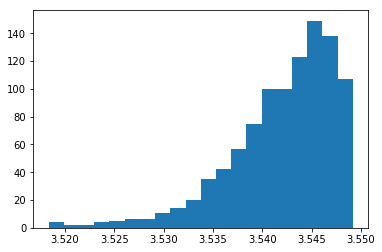

In [6]:
dit.set_positioner_theta(0*u.deg)
dit.set_positioner_phi(0*u.deg)
dit.make_positioner_rotation()
dit.set_boresight_position(20.*u.deg, 24.5*u.deg+1*u.arcsec)
dit.run_simulation(source_type, *source, report=False)
num_iterations = 1000
snr_b = []
snr_r = []
snr_z = []
for i in range(num_iterations):
    # move the fiber to its initial point before randomly moving it
    dit.set_focal_plane_position()
    dit.add_random_offset_fiber_position()
    dit.run_simulation(source_type, *source, report=False)
    snr_b.append(np.median(dit.SNR['b'][0]))
    snr_r.append(np.median(dit.SNR['r'][0]))
    snr_z.append(np.median(dit.SNR['z'][0]))
plt.clf()
plt.hist(snr_b, bins = 20)
plt.show()

### Testing random offsets - random boresight altitude offsets

/home/tyapici/Projects/desi/code/specsim/specsim/simulator.py:552: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/home/tyapici/Projects/desi/code/specsim/specsim/simulator.py:556: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


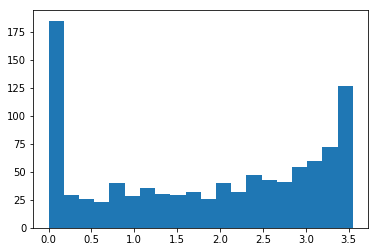

In [7]:
dit.set_positioner_theta(0*u.deg)
dit.set_positioner_phi(0*u.deg)
dit.make_positioner_rotation()
dit.set_boresight_position(20.*u.deg, 24.5*u.deg)
dit.set_focal_plane_position()
dit.run_simulation(source_type, *source, report=False)
num_iterations = 1000
snr_b = []
snr_r = []
snr_z = []
for i in range(num_iterations):
    # move the fiber to its initial point before randomly moving it
    #dit.set_focal_plane_position()
    dit.set_boresight_position(20.*u.deg, 24.5*u.deg)
    dit.set_focal_plane_position()
    dit.add_random_boresight_offset(var_az=0*u.arcsec)
    dit.run_simulation(source_type, *source, report=False)
    snr_b.append(np.median(dit.SNR['b'][0]))
    snr_r.append(np.median(dit.SNR['r'][0]))
    snr_z.append(np.median(dit.SNR['z'][0]))
plt.clf()
plt.hist(snr_b, bins = 20)
plt.show()

### Testing random offsets - random boresight azimuth offsets

/home/tyapici/Projects/desi/code/specsim/specsim/simulator.py:552: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/home/tyapici/Projects/desi/code/specsim/specsim/simulator.py:556: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


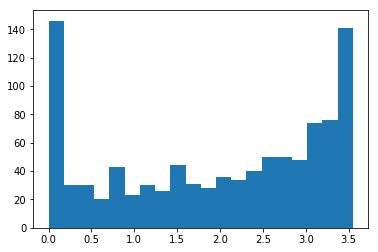

In [8]:
dit.set_positioner_theta(0*u.deg)
dit.set_positioner_phi(0*u.deg)
dit.make_positioner_rotation()
dit.set_boresight_position(20.*u.deg, 24.5*u.deg)
dit.set_focal_plane_position()
dit.run_simulation(source_type, *source, report=False)
num_iterations = 1000
snr_b = []
snr_r = []
snr_z = []
for i in range(num_iterations):
    # move the fiber to its initial point before randomly moving it
    #dit.set_focal_plane_position()
    dit.set_boresight_position(20.*u.deg, 24.5*u.deg)
    dit.set_focal_plane_position()
    dit.add_random_boresight_offset(var_alt=0*u.arcsec)
    dit.run_simulation(source_type, *source, report=False)
    snr_b.append(np.median(dit.SNR['b'][0]))
    snr_r.append(np.median(dit.SNR['r'][0]))
    snr_z.append(np.median(dit.SNR['z'][0]))
plt.clf()
plt.hist(snr_b, bins = 20)
plt.show()

### Testing random offsets - random boresight azimuth and altitude offsets

/home/tyapici/Projects/desi/code/specsim/specsim/simulator.py:552: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/home/tyapici/Projects/desi/code/specsim/specsim/simulator.py:556: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


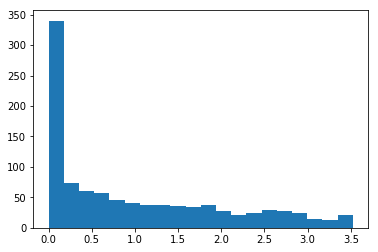

In [9]:
dit.set_positioner_theta(0*u.deg)
dit.set_positioner_phi(0*u.deg)
dit.make_positioner_rotation()
dit.set_boresight_position(20.*u.deg, 24.5*u.deg)
dit.set_focal_plane_position()
dit.run_simulation(source_type, *source, report=False)
num_iterations = 1000
snr_b = []
snr_r = []
snr_z = []
for i in range(num_iterations):
    # move the fiber to its initial point before randomly moving it
    #dit.set_focal_plane_position()
    dit.set_boresight_position(20.*u.deg, 24.5*u.deg)
    dit.set_focal_plane_position()
    dit.add_random_boresight_offset()
    dit.run_simulation(source_type, *source, report=False)
    snr_b.append(np.median(dit.SNR['b'][0]))
    snr_r.append(np.median(dit.SNR['r'][0]))
    snr_z.append(np.median(dit.SNR['z'][0]))
plt.clf()
plt.hist(snr_b, bins = 20)
plt.show()